## Getting starting with data analysis in python
Previously, I've only done data analysis in R. Here's my first real try of doing something besides linear regression/GLMs in Python.

The titanic dataset is a dataset of the passengers onboard the ill-fated titanic when it sunk over a century ago. Let's see if we can predict whether or not a passenger would've survived based on the other characteristics we knew about them.

Let's use pandas, import the classic titanic dataset, and print the columns names, and the top 7 rows of the dataset as a sanity check/ quick look of the data we're importing. 

Note that this is the training dataset; we'll be setting aside the testing dataset to see how well our models generalize to new data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

train = pd.DataFrame.from_csv('C:/Users/vlee/PycharmProjects/Jupyter-Notebooks/Kaggle/Titanic/Data/train.csv', index_col = None) 
# Originally, I had issues importing data as the first column was not being recognized
# When you import csv files using pandas, by default the first column of the file is an index column
# index_col=None tells pandas that the first column given is a column with actual data

print("Here is a list of the column names: " + str(train.columns.values))
print("Here are the dimensions of our training dataset in (row, column) form: " + str(train.shape))
train.head(n=7)

Here is a list of the column names: ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
Here are the dimensions of our training dataset in (row, column) form: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


We have a training dataset with 891 rows, and 12 columns: 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
 'Ticket', 'Fare', 'Cabin', 'Embarked'

It looks like some of the columns may be unsuitable for prediction. Let's see what the columns are actually representing. Here's an explanation of the variables taken from Kaggle.


## Data Dictionary
survival	- Survival	0 = No, 1 = Yes

pclass	- Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	- Sex	

Age	- Age in years	

sibsp -	# of siblings / spouses aboard the Titanic	

parch -	# of parents / children aboard the Titanic	

ticket -	Ticket number	

fare -	Passenger fare	

cabin -	Cabin number	

embarked -	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


## Sanity check of variables

Some variables that should stand out are the "Name", "Ticket" and "PassengerId" columns. By intuition, the name should not be a significant determinant in whether or not someone died in a ship sinking. The same goes for the passenger id, which is just an index variable assigned to the dataset well after the event. 

In a similar fashion, the ticket number shouldn't really matter either. From pulling the first 7 ticket numbers from the data set, we see that ticket numbers have no clear meaning, as some of the ticket numbers have characters included, and the numbers range from 17463 to 373450, which means that the ticket number does not match the number of passengers either, or boarding order, as the titanic certainly did not have room for 300,000 people.

## Data Janitor Work

Since we've identified the Name, Ticket and PassengerId columns are not being particularly useful in predicting whether or not a given titanic passenger would've survived, let's drop those first. 

In [2]:
train.drop(['PassengerId','Name','Ticket'], axis = 1, inplace = True)
train.head(n=7)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
5,0,3,male,NaN,0,0,8.4583,NaN,Q
6,0,1,male,54.0,0,0,51.8625,E46,S


Looks better. Looks like we might have some missing data (The fifth entry has a missing age value, and the Cabin column has many missing values - 'NaN'). Let's see if we have any missing data values elsewhere in the training dataset.

In [3]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Looks like we have some missing data. The Age, Cabin, and Embarked columns have some missing values. We will need to deal with this. 

A lot of records are missing cabin numbers. Cabin numbers seem to be formatted with a combination of a letter at the beginning, followed by a number. While the letter at the beginning may indicate what section of the ship the passenger was in, "pclass" would be an excellent proxy, as what class your ticket was determined what section of the ship you were placed in, and it has no missing values. 

Let's remove the "Cabin" column.

The age and the embarked columns are a little more problematic however, and cannot be dealt with by simply removing their columns. 

We can remove the data entries/ passengers who have missing embarkation data, as there are only two passengers who are missing embarkation data. However, with regards to age, we could drop the age column, but that leaves the issue of us dropping a lot of data - age certainly was a factor in one's survival on the titanic - "women and children first". 

We could just exlude the passenger entries with missing age values, but we don't know how many passengers in the testing data set lack ages. What will happen if our model, if trained with age as an input, needs to guess whether or not a passenger whose age is unknown survived? 

For now, let's just exclude the passengers with missing age values from our training dataset. 

In [4]:
train.drop(['Cabin'], axis = 1, inplace = True)
train.dropna(subset = ["Age","Embarked"], inplace = True)
print(train.isnull().sum())
print("Here are the dimensions of our training dataset in (row, column) form: " + str(train.shape))
train.head(n=7)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Here are the dimensions of our training dataset in (row, column) form: (712, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S


Much better. Worth nothing however, is the fact that our training now only has 712 observations, compared to the original 891, a 20% reduction.

Now's lets get some summary statistics of the columns to get an idea of how the data is distributed, and to see if there are any persisting issues with data quality.

In [5]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


Since survived is really just a binary variable, with 1 meaning the passenger survived the sinking and 0 meaning the passenger did not, the mean of the survived variable is actually the proportion of passengers who survived. 

Pclass's statistics is probably the least interpretable. While the values for Pclass are numeric (1, 2, 3), Pclass should really be a categorical variable. Categorical variable tell us the quality of something, numeric values tell us the quantity. 

The statistics for the Sex column are not displayed as it is coded as a categorical variable already, only being able to take on the values of "male" and "female" as opposed to numbers like Pclass. The same goes for the embarked column. 

Age, SibSp, Parch, and Fare all look normal. 
SibSp and Parch only take on integer values in the their histograms, which at least shows that there aren't obvious data quality issues.

Average age is 29.64. Worth noting is that there are two "humps" in the distribution (see age histogram below), with one being near the mean of 29.64, and another smaller one near age 0, which suggests that there was a significant population of infants and children aboard. 

The average number of siblings/spouses a given passenger had was 0.51
The average number of parents/children a given passenger had was 0.43
The average fare paid by passengers is 34.56

Let's plot histograms of the variables, and see if there are any issues in the data.

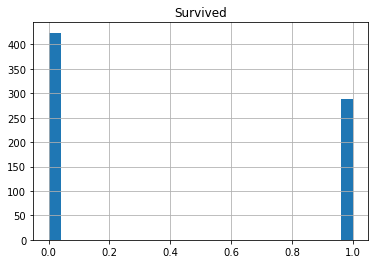

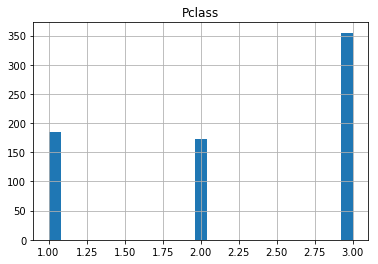

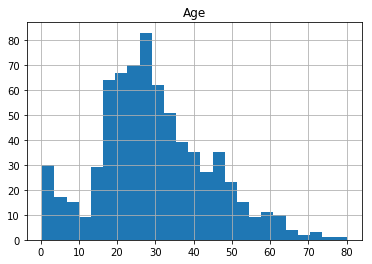

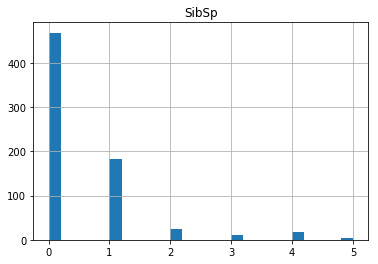

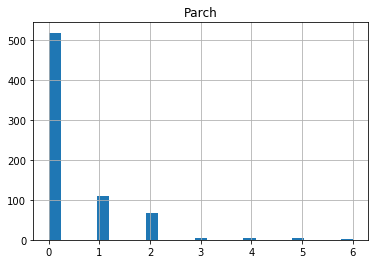

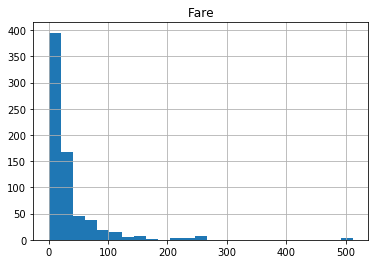

In [6]:
for column_name in train.columns.values:
    try:
        histo = train.hist(column = column_name, bins = 25)
        plt.show()
    except:
        pass 
# use try/except because pandas will give you an error if you try to plot a histogram of a column with non-number values

Histograms are in line with expectations based off the descriptive statistics, and are in line with intuition and common sense (i.e. no negative numbers for any of the variables, and integer only values for SibSp and Parch) 

Since logistic regressions can only accept numerical input, we need turn several variables into dummy variables.
Instead of having C, Q, and S as the values for the Embarked variable, we'll just have dummy variables. For example: let Embarked C be equal to 1 if the value for the Embarked column was C, and 0 otherwise, and the same for Embarked Q and S. 

As mentioned before, we need to process the Pclass column and turn it into a categorical variable. The same goes for the Sex and Embarked columns.

In [7]:
train = pd.get_dummies(data = train, columns = ['Pclass', 'Sex', 'Embarked'])
train.head(n = 7)

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1
6,0,54.0,0,0,51.8625,1,0,0,0,1,0,0,1
7,0,2.0,3,1,21.0750,0,0,1,0,1,0,0,1


Everything looks good. We'll need to drop one dummy variable for each of our three original categorical variables. This is so we can establish a "baseline" category. For example, if we drop the sex_male column, the model will assume the passenger is male unless otherwise specified by the sex_female column with a 1. We'll pick the most common category for each categorical variable to be our baseline (see histograms above), and in this case, the baseline assumption is 3rd class, Male, and embarked at Southhampton, until otherwise specified.

In [8]:
train.describe()
train.drop(['Pclass_3', 'Sex_male', 'Embarked_S'], axis = 1, inplace = True)
train.head(n = 7)

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Sex_female,Embarked_C,Embarked_Q
0,0,22.0,1,0,7.2500,0,0,0,0,0
1,1,38.0,1,0,71.2833,1,0,1,1,0
2,1,26.0,0,0,7.9250,0,0,1,0,0
3,1,35.0,1,0,53.1000,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,0,0,0
6,0,54.0,0,0,51.8625,1,0,0,0,0
7,0,2.0,3,1,21.0750,0,0,0,0,0


# Model Fitting
## Generalized Linear Model (Logistic Regression)

Let's finally build a model to predict passenger survivorship based off our now cleaned data. We'll be fitting a logistic regression (a kind of Generalized Linear Model or GLM) which will output a number between 0 and 1, with 0 being a prediction of dying, and 1 being a prediction of surviving. We can interpret numbers between 0 and 1 as how likely a passenger with the given attributes would survive.

In [9]:
import statsmodels.api as sm
train_cols =  train.columns[1:]
logit = sm.Logit(train['Survived'], train[train_cols])
result = logit.fit()
print(result.summary())

C:\Users\vlee\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.452866
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            8
Date:                Mon, 29 Jan 2018   Pseudo R-squ.:                  0.3289
Time:                        16:29:13   Log-Likelihood:                -322.44
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 1.595e-63
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0661      0.006    -11.569      0.000      -0.077      -0.055
SibSp         -0.5178      0.

The above table is a table of the results from training our logistic model. Some figures to note are the Pseudo R-Squared figure which shows how good our model predicts survival, and the various coefficients of our variables and their respective P-values, which shows the relative "importance" of our variables in determining survival.

In [10]:
import numpy as np
from IPython.display import display
train_age = train.copy() #save the dataframe before we add our predictions to it
train['Probability'] = result.predict(train[train_cols])
train['Predicted'] = np.where(train['Probability'] >= 0.5, 1 ,0)
train.head(n = 7)

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Sex_female,Embarked_C,Embarked_Q,Probability,Predicted
0,0,22.0,1,0,7.2500,0,0,0,0,0,0.122793,0
1,1,38.0,1,0,71.2833,1,0,1,1,0,0.910778,1
2,1,26.0,0,0,7.9250,0,0,1,0,0,0.695323,1
3,1,35.0,1,0,53.1000,1,0,1,0,0,0.907727,1
4,0,35.0,0,0,8.0500,0,0,0,0,0,0.090530,0
6,0,54.0,0,0,51.8625,1,0,0,0,0,0.270818,0
7,0,2.0,3,1,21.0750,0,0,0,0,0,0.145319,0


If we use the model we've trained using the training set, we can output the model's confidence of a given passenger surviving, as seen in the probability column. To better evaluate model performance, we discretize the confidence output: survival probabilities above 0.5 will be considered to have survived and less than 0.5 will be considered to have died. 

In [11]:
from sklearn.metrics import confusion_matrix
# confusion_matrix(train['Survived'], train['Predicted'])

train_cmatrix = pd.crosstab(np.where(train['Survived'] == 1, 'Survived', 'Died'), 
                            np.where(train['Predicted'] == 1, 'Survived', 'Died'),
                            rownames=['Actual'],
                            colnames=['Predicted'],
                            margins=True)
display(train_cmatrix)

Predicted,Died,Survived,All
Actual,,,
Died,361,63,424
Survived,74,214,288
All,435,277,712


The above is a confusion matrix, which shows what happened in reality vs. what the model predicted. For example, out of the 712 passengers in the training dataset, there were 63 instances where the model predicted that they would survive, when in reality they had died. 

We can use the F1 score to quantify how well our GLM is performing. It is the harmonic average of precision and recall, with precision being the proportion of predicted survivors that had actually survived, and recall being the proportion of all actual survivors being predicted to survive. 

In [12]:
train_tp = train_cmatrix['Survived']['Survived']
train_fp = train_cmatrix['Survived']['Died']
train_fn = train_cmatrix['Died']['Survived']
train_precision = train_tp/(train_tp + train_fp)
train_recall = train_tp/(train_tp + train_fn)
train_f1 = 2/(train_precision**-1 + train_recall**-1)
print("The F1 Score of the model on the training dataset is " + str(train_f1))

The F1 Score of the model on the training dataset is 0.757522123894


F1 scores range from 0 to 1, where 1 is perfect performance (all actual survivors are predicted to survive by the model, with no false positives/ negatives). Our model is, at the very least, acceptable, and is doing better than random guessing. 

In [13]:
survival = pd.DataFrame.from_csv('C:/Users/vlee/PycharmProjects/Jupyter-Notebooks/Kaggle/Titanic/Data/gender_submission.csv', index_col = None)
test = pd.DataFrame.from_csv('C:/Users/vlee/PycharmProjects/Jupyter-Notebooks/Kaggle/Titanic/Data/test.csv', index_col = None)
test.drop(['Name','Ticket','Cabin'], axis = 1, inplace = True)
test = pd.get_dummies(data = test, columns = ['Pclass', 'Sex', 'Embarked'])
test = survival.merge(test, on = 'PassengerId')
print("Here are the dimensions of our testing dataset, before removing rows with missing data, in (row, column) form: " + str(test.shape))

test_missing = test[pd.isnull(test['Age'])].copy()

test.dropna(subset = ['Age'], inplace = True)
test.drop(['PassengerId', 'Pclass_3', 'Sex_male', 'Embarked_S'], axis = 1, inplace = True)
test_cols = test.columns[1:]
test['Probability'] =  result.predict(test[test_cols])
test['Predicted'] = np.where(test['Probability'] >= 0.5, 1, 0)
print("Here are the dimensions of our testing dataset, after removing rows with missing data, in (row, column) form: " + str(test.shape))
test.head(n = 7)



Here are the dimensions of our testing dataset, before removing rows with missing data, in (row, column) form: (418, 14)
Here are the dimensions of our testing dataset, after removing rows with missing data, in (row, column) form: (332, 12)


,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Sex_female,Embarked_C,Embarked_Q,Probability,Predicted
0,0,34.5,0,0,7.8292,0,0,0,0,1,0.048680,0
1,1,47.0,1,0,7.0000,0,0,1,0,0,0.253208,0
2,0,62.0,0,0,9.6875,0,1,0,0,1,0.022485,0
3,0,27.0,0,0,8.6625,0,0,0,0,0,0.144568,0
4,1,22.0,1,1,12.2875,0,0,1,0,0,0.615876,1
5,0,14.0,0,0,9.2250,0,0,0,0,0,0.285355,0
6,1,30.0,0,0,7.6292,0,0,1,0,1,0.465603,0


It appears that around 20% of our testing data has missing age values, and needed to be removed. This is similar to the proportion of passengers we removed from the training set. We will deal with predictions for passengers with missing data values later. For now, let's see how our model performs on passengers with complete infomration.

In [14]:
test_cmatrix = pd.crosstab(np.where(test['Survived'] == 1, 'Survived', 'Died'), 
                            np.where(test['Predicted'] == 1, 'Survived', 'Died'),
                            rownames=['Actual'],
                            colnames=['Predicted'],
                            margins=True)
display(test_cmatrix)
test_tp = test_cmatrix['Survived']['Survived']
test_fp = test_cmatrix['Survived']['Died']
test_fn = test_cmatrix['Died']['Survived']
test_precision = test_tp/(test_tp + test_fp)
test_recall = test_tp/(test_tp + test_fn)
test_f1 = 2/(test_precision**-1 + test_recall**-1)
print("The F1 Score of the model on the test dataset is " + str(test_f1))

Predicted,Died,Survived,All
Actual,,,
Died,184,21,205
Survived,14,113,127
All,198,134,332


The F1 Score of the model on the test dataset is 0.865900383142


Strangely enough, the model seems to have a better time predicting survival on the testing set, a set it's never "seen" before, as opposed to the training set on which it was trained on. This is a sign that the model generalizes well, as opposed to being overfit. This might be a sign that the model isn't learning as much as it could be from the training set. 

But what about all the passengers whose ages weren't recorded? We could simply just not predict survival chances for them, but that's honestly a cheap cop-out, and we're ignoring around 20% of all passengers.

We could train another GLM that doesn't rely on age information, but based on historical("Women and children first!") and statistical(The age variable in our original GLM is highly significant in determining survival chances) reasons, that would not be a good idea. We would weaken the predictive power of our model.

Since our GLM only takes passengers whose information records are complete we need to find away to deal with people without ages recorded.

A fast, basic approach to data imputation is to simply take the mean value of the column with missing values, and use the mean to fill in observations with missing variable. 

In [15]:
test_missing.head(n = 7)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
10,902,0,NaN,0,0,7.8958,0,0,1,0,1,0,0,1
22,914,1,NaN,0,0,31.6833,1,0,0,1,0,0,0,1
29,921,0,NaN,2,0,21.6792,0,0,1,0,1,1,0,0
33,925,1,NaN,1,2,23.4500,0,0,1,1,0,0,0,1
36,928,1,NaN,0,0,8.0500,0,0,1,1,0,0,0,1
39,931,0,NaN,0,0,56.4958,0,0,1,0,1,0,0,1
41,933,0,NaN,0,0,26.5500,1,0,0,0,1,0,0,1


In [16]:
test_missing.loc[:, 'Age'] = train['Age'].mean()
test_missing.head(n = 7)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
10,902,0,29.642093,0,0,7.8958,0,0,1,0,1,0,0,1
22,914,1,29.642093,0,0,31.6833,1,0,0,1,0,0,0,1
29,921,0,29.642093,2,0,21.6792,0,0,1,0,1,1,0,0
33,925,1,29.642093,1,2,23.4500,0,0,1,1,0,0,0,1
36,928,1,29.642093,0,0,8.0500,0,0,1,1,0,0,0,1
39,931,0,29.642093,0,0,56.4958,0,0,1,0,1,0,0,1
41,933,0,29.642093,0,0,26.5500,1,0,0,0,1,0,0,1


In [17]:
test_missing_cols = test_missing.columns[1:]
test_missing['Probability'] =  result.predict(test_missing[test_cols])
test_missing['Predicted'] = np.where(test_missing['Probability'] >= 0.5, 1, 0)
test_missing.head(n = 7)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Probability,Predicted
10,902,0,29.642093,0,0,7.8958,0,0,1,0,1,0,0,1,0.124213,0
22,914,1,29.642093,0,0,31.6833,1,0,0,1,0,0,0,1,0.958551,1
29,921,0,29.642093,2,0,21.6792,0,0,1,0,1,1,0,0,0.059698,0
33,925,1,29.642093,1,2,23.4500,0,0,1,1,0,0,0,1,0.468212,0
36,928,1,29.642093,0,0,8.0500,0,0,1,1,0,0,0,1,0.642094,1
39,931,0,29.642093,0,0,56.4958,0,0,1,0,1,0,0,1,0.128518,0
41,933,0,29.642093,0,0,26.5500,1,0,0,0,1,0,0,1,0.645512,1


In [18]:
test_missing_cmatrix = pd.crosstab(np.where(test_missing['Survived'] == 1, 'Survived', 'Died'), 
                            np.where(test_missing['Predicted'] == 1, 'Survived', 'Died'),
                            rownames=['Actual'],
                            colnames=['Predicted'],
                            margins=True)
display(test_missing_cmatrix)
test_missing_tp = test_missing_cmatrix['Survived']['Survived']
test_missing_fp = test_missing_cmatrix['Survived']['Died']
test_missing_fn = test_missing_cmatrix['Died']['Survived']
test_missing_precision = test_missing_tp/(test_missing_tp + test_missing_fp)
test_missing_recall = test_missing_tp/(test_missing_tp + test_missing_fn)
test_missing_f1 = 2/(test_missing_precision**-1 + test_missing_recall**-1)
print("The F1 Score of the model on the test dataset is " + str(test_missing_f1))

Predicted,Died,Survived,All
Actual,,,
Died,54,7,61
Survived,15,10,25
All,69,17,86


The F1 Score of the model on the test dataset is 0.47619047619


After replacing the missing passenger ages with the average passenger age from the training set, we get a lower F1 score compared to the F1 score of the testing dataset without missing age values. 

While now we can finally predict the survival of passengers whose age is unknown, the fact that we imputed age with the average age seems to have had a negative impact in terms of model performance. This is because age is one of the variables with the highest impact on survival (see the z-values from the logistic model regression results), and we lose a lot of predictive power if we just use the average age. 

Since we have age data on roughly 80% of the passengers, we can impute the missing ages using another model: this time, we'll try to predict the passenger's age based on the remaining variables. 

In [19]:
train.drop(['Survived', 'Probability', 'Predicted'], axis = 1, inplace = True)
train[train.Age == 1]

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Sex_female,Embarked_C,Embarked_Q
164,1.0,4,1,39.6875,0,0,0,0,0
172,1.0,1,1,11.1333,0,0,1,0,0
183,1.0,2,1,39.0000,0,1,0,0,0
381,1.0,0,2,15.7417,0,0,1,1,0
386,1.0,5,2,46.9000,0,0,0,0,0
788,1.0,1,2,20.5750,0,0,0,0,0
827,1.0,0,2,37.0042,0,1,0,1,0
